<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 13 09:45:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 25
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 42
OUTPUT_Y = 1
OUTPUT_D = 5

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Conv2d(12, 12, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 128

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 256
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :21]
        b = ab[:, 21:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)
        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_class_fixed_x'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [46]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

 10%|█         | 1/10 [00:12<01:50, 12.27s/it]

200


 20%|██        | 2/10 [00:24<01:38, 12.35s/it]

200


 30%|███       | 3/10 [00:37<01:26, 12.33s/it]

200


 40%|████      | 4/10 [00:49<01:13, 12.29s/it]

200


 50%|█████     | 5/10 [01:01<01:02, 12.41s/it]

200


 60%|██████    | 6/10 [01:14<00:50, 12.54s/it]

200


 70%|███████   | 7/10 [01:27<00:37, 12.56s/it]

200


 80%|████████  | 8/10 [01:40<00:25, 12.58s/it]

200


 90%|█████████ | 9/10 [01:52<00:12, 12.57s/it]

200


  0%|          | 0/1 [00:00<?, ?it/s]

200


  0%|          | 0/6 [00:00<?, ?it/s]

200


 17%|█▋        | 1/6 [00:11<00:58, 11.75s/it]

200


 33%|███▎      | 2/6 [00:23<00:46, 11.73s/it]

200


 50%|█████     | 3/6 [00:35<00:35, 11.92s/it]

200


 67%|██████▋   | 4/6 [00:48<00:24, 12.12s/it]

200


 83%|████████▎ | 5/6 [01:00<00:12, 12.16s/it]

200


100%|██████████| 6/6 [01:12<00:00, 12.16s/it]

200
2000
200
1200


In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [48]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

[[[[ 11.3439      11.702058    12.929133   ... -19.991825
    -20.52794    -20.694681  ]
   [ 11.3439      11.876684    13.281346   ... -17.524021
    -18.121374   -18.348562  ]
   [ 11.3439      12.071741    13.644921   ... -11.935909
    -12.220692   -12.353026  ]
   ...
   [ 11.3439      11.463964    12.568454   ... -11.451214
    -11.610211   -11.629511  ]
   [ 11.3439      11.561357    12.674354   ... -17.008638
    -17.467648   -17.611465  ]
   [ 11.3439      11.702058    12.929133   ... -19.991825
    -20.52794    -20.694681  ]]]


 [[[ -1.5638598   -1.8543103   -1.9217935  ... -45.766457
    -47.399532   -48.003857  ]
   [ -1.5638598   -3.8925838   -5.504233   ... -34.36903
    -35.266094   -35.626465  ]
   [ -1.5638598   -6.357992    -5.6890774  ... -19.378668
    -19.604916   -19.734627  ]
   ...
   [ -1.5638598    0.80569327   1.8718169  ... -32.397247
    -32.720184   -32.88802   ]
   [ -1.5638598   -0.31315097   0.6157154  ... -37.01079
    -37.93553    -38.317066  ]
   [ 

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.0, 1.0, 2.0, 1.5])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    #parse labels
                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, y_p, d = net(x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    #error = (pred - y) / y
                    #error = error.mean(0)
                    #train_errors.append(error.to("cpu"))

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    la = val_y[:, 0]
                    lb = val_y[:, 1]
                    ly = val_y[:,2]
                    ld = val_y[:, 3]
                    a, b, y_p, d = net(val_x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    val_losses.append(loss.item())

                    #val_error = (val_pred - val_y) / val_y
                    #val_error = val_error.mean(0)
                    #val_errors.append(val_error.to("cpu"))

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                #train_error = np.average(train_errors)
                #val_error= np.average(val_errors)

                train_losses = []
                val_losses = []
                #train_errors = []
                #val_errors = []

                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                #print("error : ", train_error, "val error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [57]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)


  0%|          | 1/1000 [00:04<1:22:01,  4.93s/it]


loss :  118.7694487991333 val loss :  80.75987396240234 

Validation loss decreased (inf --> 80.759874).  Saving model ...



  0%|          | 2/1000 [00:09<1:22:06,  4.94s/it]


loss :  59.680300035476684 val loss :  78.88679275512695 

Validation loss decreased (80.759874 --> 78.886793).  Saving model ...



  0%|          | 3/1000 [00:14<1:21:58,  4.93s/it]


loss :  45.043204374313355 val loss :  26.59118995666504 

Validation loss decreased (78.886793 --> 26.591190).  Saving model ...



  0%|          | 4/1000 [00:19<1:21:57,  4.94s/it]


loss :  34.99301048851013 val loss :  37.80676422119141 

EarlyStopping counter: 1 out of 25



  0%|          | 5/1000 [00:24<1:21:47,  4.93s/it]


loss :  28.557947950363157 val loss :  51.66074066162109 

EarlyStopping counter: 2 out of 25



  1%|          | 6/1000 [00:29<1:21:54,  4.94s/it]


loss :  22.099494119644167 val loss :  50.82488021850586 

EarlyStopping counter: 3 out of 25



  1%|          | 7/1000 [00:34<1:21:50,  4.94s/it]


loss :  20.887621227264404 val loss :  44.03485946655273 

EarlyStopping counter: 4 out of 25



  1%|          | 8/1000 [00:39<1:21:40,  4.94s/it]


loss :  20.309581394195558 val loss :  56.62348861694336 

EarlyStopping counter: 5 out of 25



  1%|          | 9/1000 [00:44<1:21:28,  4.93s/it]


loss :  19.995558835983278 val loss :  55.793025207519534 

EarlyStopping counter: 6 out of 25


KeyboardInterrupt: ignored

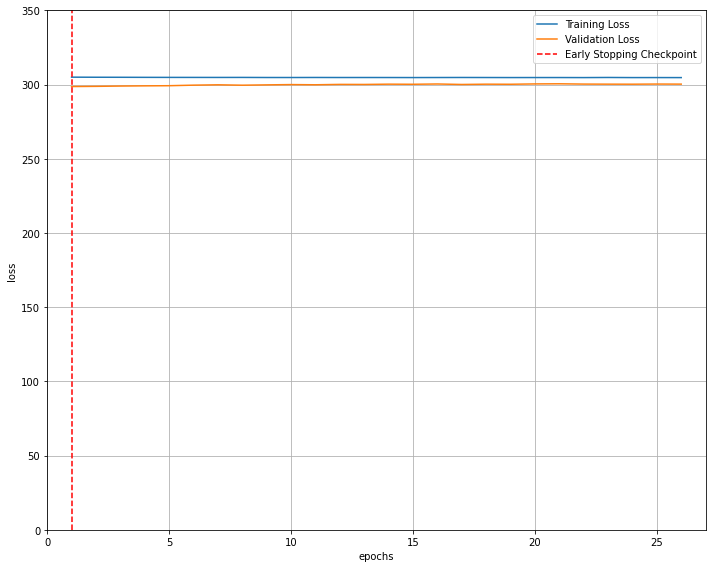

In [35]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, y_p, d = net(x)

            #get class of a, b, d
            _, aa = a.max(1)
            _, bb = b.max(1)
            _, dd = d.max(1)

            aa = aa.to("cpu")
            bb = bb.to("cpu")
            y_p = y_p.to("cpu")
            dd = dd.to("cpu")

            predict.append(aa)
            predict.append(bb)
            predict.append(y_p)
            predict.append(dd)
            predict = np.array(predict)
            predictions.append(predict)
            

    #print(predictions)
    #print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [0]:
testsets = []
for f in tqdm(os.listdir(TEST_PATH_LABEL)):
  path  = os.path.join(TEST_PATH_LABEL, f)
  testset = DataCaller_Excel(path, IMG_SIZE)
  print(testset.__len__())
  testsets.append(testset)

testset = ConcatDataset(testsets)






  0%|          | 0/1 [00:00<?, ?it/s]




100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

150


In [0]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()
test(trained_net)